# Business-Level Analysis of Yelp Data (Arizona)




### Objective
Analyze business metadata, reviews, and ratings to understand patterns in Arizona.

### Environment
- Hadoop HDFS for storage
- Spark SQL & DataFrames for analytics
- Data filtered to Arizona and converted to Parquet for efficiency

### Approach
1. Load business and review JSON files into Spark DataFrames
2. Filter businesses located in Arizona
3. Choose a business category (e.g., Restaurants)
4. Join with review data and compute aggregated metrics

In [122]:
#Importing Files
from pyspark.sql import SparkSession

In [123]:
#Connect to PySpark Session
spark = SparkSession.builder \
    .appName("YelpDataAnalysis") \
    .getOrCreate()

In [124]:
#Reading json files in spark
bizz_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
checkin_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [125]:
#Business Schema
bizz_df.printSchema()
bizz_df.show(5)

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [126]:
#Checkin Schema
checkin_df.printSchema()
checkin_df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|2020-03-13 21:10:...|
|--0iUa4sNDFiZFrAd...|2010-09-13 21:43:...|
|--30_8IhuyMHbSOcN...|2013-06-14 23:29:...|
|--7PUidqRWpRSpXeb...|2011-02-15 17:12:...|
|--7jw19RH9JKXgFoh...|2014-04-21 20:42:...|
+--------------------+--------------------+
only showing top 5 rows



In [127]:
#Review Schema
review_df.printSchema()
review_df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPp

In [128]:
#Tip Schema
tip_df.printSchema()
tip_df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|3uLgwr0qeCNMjKenH...|               0|2012-05-18 02:17:21|Avengers time wit...|AGNUgVwnZUey3gcPC...|
|QoezRbYQncpRqyrLH...|               0|2013-02-05 18:35:10|They have lots of...|NBN4MgHP9D3cw--Sn...|
|MYoRNLb5chwjQe3c_...|               0|2013-08-18 00:56:08|It's open even wh...|-copOvldyKh1qr-vz...|
|hV-bABTK-glh5wj31...|               0|2017-06-27 23:05:38|Very decent fried...|FjMQVZjSqY8syIO-5...|
|_uN0OudeJ3Zl_tf6n...|               0|2012-10-06 19:43:09|Appetizers.. plat...|

In [129]:
#User Schema
user_df.printSchema()
user_df.show(5)

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|         3.91|    

In [130]:
#Filtering Businesses in Arizona
arizona_df = bizz_df.filter(bizz_df["state"] == "AZ")

#Show first few rows
arizona_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|5255 E Broadway Blvd|{null, null, null...|tUFrWirKiKi_TAnsV...|Department Stores...|Tucson|{8:0-23:0, 8:0-22...|      0| 32.223236| -110.880452|              Target|      85711|          22|  3.5|   AZ|
|     625 N Stone Ave|{null, null, null...|rBmpy_Y1UbBx8ggHl...|Automotive, Auto ...|Tucson|{8:0-17:0, 0:0-0:...|      1|32.2298719|-110.9723419|Arizona Truck Out...|      85705|      

In [131]:
# arizona_df.write.parquet("file:///home/dps/Documents/temp/arizona_businesses.parquet")

In [132]:
# Checking out the various categories of business
category=bizz_df.select("categories").distinct().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                                   |
+-----------------------------------------------------------------------------------------------------------------------------+
|Arts & Entertainment, Event Planning & Services, Venues & Event Spaces, Museums                                              |
|Food, Convenience Stores, Restaurants, Food Delivery Services, Local Flavor, Delis                                           |
|Automotive, Auto Repair, Towing, Body Shops, Oil Change Stations, Auto Parts & Supplies, Tires                               |
|Makeup Artists, Hair Salons, Beauty & Spas                                                                                   |
|Breweries, American (New), Restaurants, Burgers, American (Traditional), Gastropubs, Brewpubs, Food, Fi

In [133]:
# Filter for businesses in the 'Salons' category and ccounting entries
salons_df = arizona_df.filter(arizona_df["categories"].contains("Salon"))
rows_count=salons_df.count()
rows_count

554

In [134]:
# Show Salon dataset
salons_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|        city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|8567 N Silverbell...|{null, null, null...|YG0OOMLP3MWYPKHpk...|Men's Hair Salons...|      Tucson|{9:0-17:30, null,...|      0|32.3622562294|-111.1197053374|           S&K Salon|      85743|           6|  4.0|   AZ|
|11901 N 1st Ave, ...|{null, null, null...|en_F2VgZPW1RCnWkP...|Nail Salons, Beau...|  Oro Valley|{9:0-19:0, 9:0-19...|      1|   32.422

In [135]:
#Creating Temporary views for all the datasets
salons_df.createOrReplaceTempView("salons")
checkin_df.createOrReplaceTempView("checkin")
review_df.createOrReplaceTempView("review")
tip_df.createOrReplaceTempView("tip")
user_df.createOrReplaceTempView("user")

In [136]:
# View Salons dataset
spark.sql("""
SELECT * from salons limit 10
""").show(truncate=False)

+-------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+-----------------------------------------------------------------------------------------------------+------------+-----------------------------------------------------------------------+-------+-------------+---------------+---------------------------------+-----------+------------+-----+-----+
|address                                          |attributes                                                                                                             

**SCATTER PLOT FOR SALON LOCATION DISTRIBUTION ACROSS ARIZONA STATE**

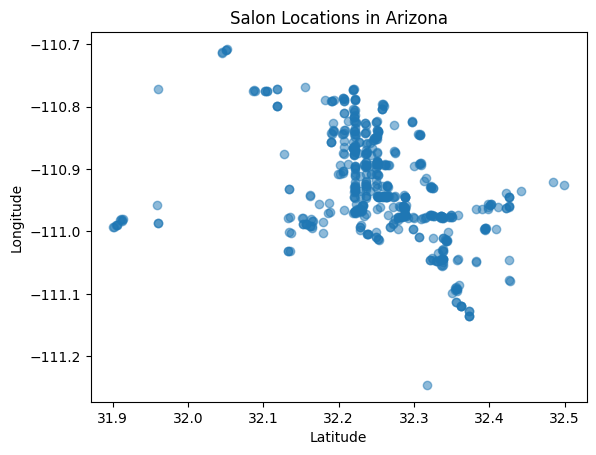

In [137]:
import matplotlib.pyplot as plt
pandas_df = salons_df.toPandas()
plt.scatter(pandas_df['latitude'],pandas_df['longitude'], alpha=0.5)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Salon Locations in Arizona')
plt.show()

In [138]:
#Query 1 - inds the top 10 most common category combinations for open salons and their business counts.

spark.sql("""
select categories, count(business_id) as bizz_count
from salons
where is_open=1
group by categories
order by bizz_count desc
limit 10
""").show(truncate=False)

+------------------------------------------------+----------+
|categories                                      |bizz_count|
+------------------------------------------------+----------+
|Nail Salons, Beauty & Spas                      |56        |
|Beauty & Spas, Nail Salons                      |49        |
|Hair Salons, Beauty & Spas                      |22        |
|Beauty & Spas, Hair Salons                      |19        |
|Hair Salons, Hair Stylists, Beauty & Spas       |6         |
|Hair Stylists, Beauty & Spas, Hair Salons       |5         |
|Waxing, Beauty & Spas, Nail Salons, Hair Removal|4         |
|Beauty & Spas, Hair Salons, Hair Stylists       |4         |
|Hair Salons, Beauty & Spas, Hair Stylists       |4         |
|Beauty & Spas, Hair Salons, Barbers             |3         |
+------------------------------------------------+----------+



**PIE CHART FOR TOP 10 CATEGORIES OF BUSINESS**

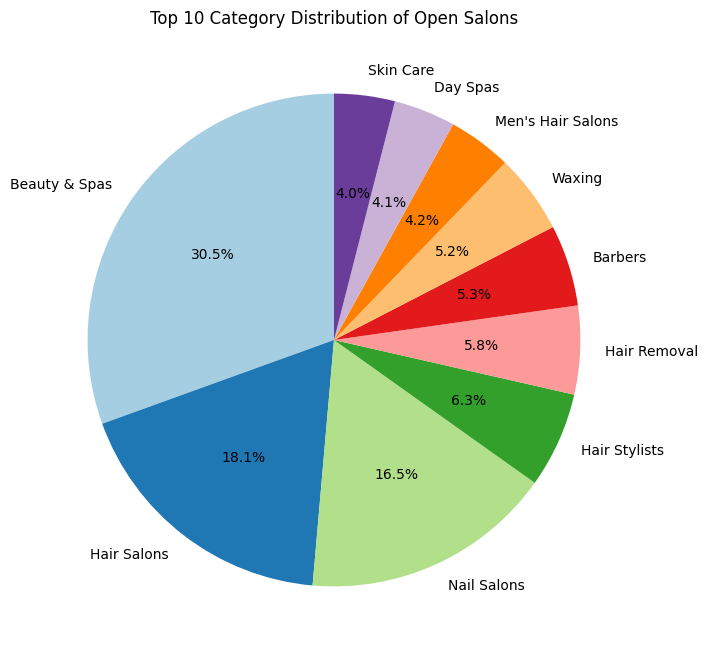

In [139]:
from pyspark.sql import functions as F
split_categories = salons_df.withColumn("category", F.explode(F.split(salons_df['categories'], ', ')))
category_counts = split_categories.filter(split_categories['is_open'] == 1) \
                                  .groupBy('category') \
                                  .count() \
                                  .orderBy(F.desc('count'))

top_categories = category_counts.limit(10)
top_categories_df = top_categories.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(top_categories_df['count'], labels=top_categories_df['category'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Top 10 Category Distribution of Open Salons')
plt.ylabel('')
plt.show()


In [140]:
#Query 2 - Calculates the average number of customers per salon for each postal code.
#Assuming all the visitors gave review for the salon
spark.sql("""
          select *, ROUND(customers/salon,0) as customer_per_salon 
          from(
            select postal_code,sum(review_count) as customers, count(*) as salon
            from salons
            where is_open=1
            group by postal_code
            order by salon desc
          )
""").show()

+-----------+---------+-----+------------------+
|postal_code|customers|salon|customer_per_salon|
+-----------+---------+-----+------------------+
|      85719|     1916|   38|              50.0|
|      85712|     1334|   37|              36.0|
|      85704|     1329|   36|              37.0|
|      85705|      934|   33|              28.0|
|      85711|     1132|   31|              37.0|
|      85710|      628|   31|              20.0|
|      85741|      825|   28|              29.0|
|      85716|      890|   22|              40.0|
|      85715|      323|   18|              18.0|
|      85743|      402|   16|              25.0|
|      85737|      516|   16|              32.0|
|      85718|      866|   15|              58.0|
|      85747|      547|   13|              42.0|
|      85748|      519|   12|              43.0|
|      85745|      291|   12|              24.0|
|      85730|      322|   11|              29.0|
|      85706|      298|   10|              30.0|
|      85614|      1

In [141]:
#Query 3 - Calculates the total number of salons, active salons, and closed salons by postal code.
salon_status_df=spark.sql("""
select a.postal_code,(a.business_count+b.business_count) as Total_salon, 
Active_salon, closed_salon 
from(
        SELECT postal_code, COUNT(business_id) AS business_count, count(is_open) as Active_salon
        FROM salons
        where is_open = 1
        GROUP BY postal_code
    ) a,
    (
        SELECT postal_code, COUNT(business_id) AS business_count, count(is_open) as closed_salon
        FROM salons
        where is_open = 0
        GROUP BY postal_code
    ) b
where a.postal_code = b.postal_code
order by Total_salon desc
""")
salon_status_df.show()

+-----------+-----------+------------+------------+
|postal_code|Total_salon|Active_salon|closed_salon|
+-----------+-----------+------------+------------+
|      85719|         50|          38|          12|
|      85712|         49|          37|          12|
|      85705|         46|          33|          13|
|      85704|         42|          36|           6|
|      85711|         39|          31|           8|
|      85710|         35|          31|           4|
|      85741|         33|          28|           5|
|      85716|         29|          22|           7|
|      85718|         21|          15|           6|
|      85715|         21|          18|           3|
|      85743|         20|          16|           4|
|      85737|         20|          16|           4|
|      85745|         14|          12|           2|
|      85747|         14|          13|           1|
|      85730|         13|          11|           2|
|      85706|         11|          10|           1|
|      85750

**BAR GRAPH FOR ACTIVE AND CLOSED SALONS AS PER POSTAL CODE**

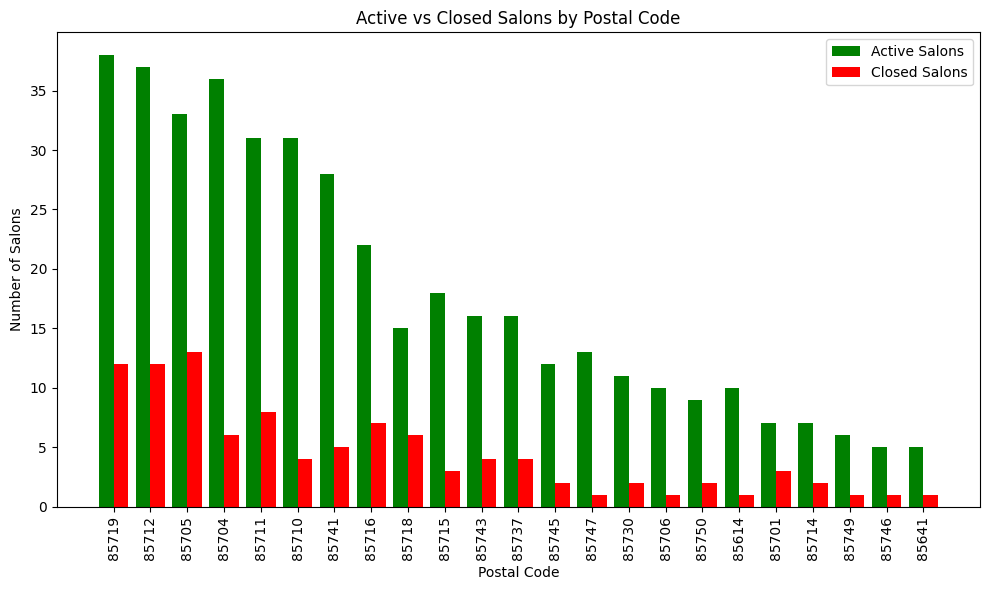

In [142]:
salon_status_pandas_df = salon_status_df.toPandas()

width = 0.4  # width of bars
x = range(len(salon_status_pandas_df))


plt.figure(figsize=(10, 6))
plt.bar(x, salon_status_pandas_df['Active_salon'], width, label='Active Salons', color='green')
plt.bar([p + width for p in x], salon_status_pandas_df['closed_salon'], width, label='Closed Salons', color='red')
plt.xlabel('Postal Code')
plt.ylabel('Number of Salons')
plt.title('Active vs Closed Salons by Postal Code')
plt.xticks([p + width / 2 for p in x], salon_status_pandas_df['postal_code'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [143]:
#Query 4 - Retrieves businesses with 5-star "useful" and "cool" reviews, and lists users with over 100 reviews 
# who is on yelp for more than 15 years
spark.sql("""
select a.business_id, a.busi_name, a.postal_code, a.stars, user.name as user_name,
2024-EXTRACT(YEAR from yelping_since) as user_on_yelp_yrs, user.review_count as user_total_review
from (
          select s.business_id,s.name as busi_name, rev.user_id, rev.stars, s.postal_code
          from salons s
          left join review rev
          on s.business_id=rev.business_id
          where rev.useful=1 and rev.cool=1 and rev.stars =5 and s.is_open=1
    ) a
join user on user.user_id=a.user_id
where user.review_count >100
and EXTRACT(YEAR from yelping_since) < 2009
order by user.review_count desc      
""").show()

+--------------------+--------------------+-----------+-----+---------+----------------+-----------------+
|         business_id|           busi_name|postal_code|stars|user_name|user_on_yelp_yrs|user_total_review|
+--------------------+--------------------+-----------+-----+---------+----------------+-----------------+
|vwl6YkyTZVt035bU-...|           Greentoes|      85705|  5.0|   Margot|              16|              922|
|_ijPwDwnqcvrNfmNN...|        Styling Etc.|      85747|  5.0|    Betsy|              17|              851|
|DPEh8VvJ7WgJpft2h...|   Belle Starr Salon|      85745|  5.0|   Amanda|              16|              444|
|vnEpznJh2EGVIFElO...|         Salon Salon|      85701|  5.0|   Amanda|              16|              444|
|HJq6nfiPa6_2FhMX-...|           Red Nails|      85711|  5.0|   Debbie|              16|              162|
|_1OKD3jnwKVFfrq6d...|The Nail Lounge O...|      85719|  5.0| Veronica|              16|              129|
+--------------------+---------------

**TOP 5 BEST PERFORMING SALONS IN AZ**

In [144]:
#Query 5 - lists the best salon in the category salons who has recieved compliment, of a postal code as per stars.
spark.sql("""
select postal_code, busi_name, stars, categories, sum(compliment_count) as compliments 
from (
    select s.postal_code, s.business_id, s.name as busi_name,
           s.stars, t.compliment_count, s.categories
    from salons s
    left join tip t
    on t.business_id = s.business_id
    where s.is_open = 1
    order by compliment_count desc, busi_name desc
) 
group by postal_code, busi_name, stars, categories
having compliments > 1
order by compliments desc
""").show()


+-----------+--------------------+-----+--------------------+-----------+
|postal_code|           busi_name|stars|          categories|compliments|
+-----------+--------------------+-----+--------------------+-----------+
|      85704|        Lovely Nails|  4.5|Nail Salons, Waxi...|          3|
|      85712|     Maple Leaf Hair|  4.5|Beauty & Spas, Ta...|          2|
|      85706|Hollywood Nails &...|  2.5|Massage Therapy, ...|          2|
|      85711|         Ulta Beauty|  3.5|Skin Care, Hair S...|          2|
|      85712|  Gadabout SalonSpas|  3.5|Day Spas, Beauty ...|          2|
+-----------+--------------------+-----+--------------------+-----------+



**HORIZONATAL BAR CHART TO REPRESENT SALON RATING IN A CITY IN INCREASING ORDER**

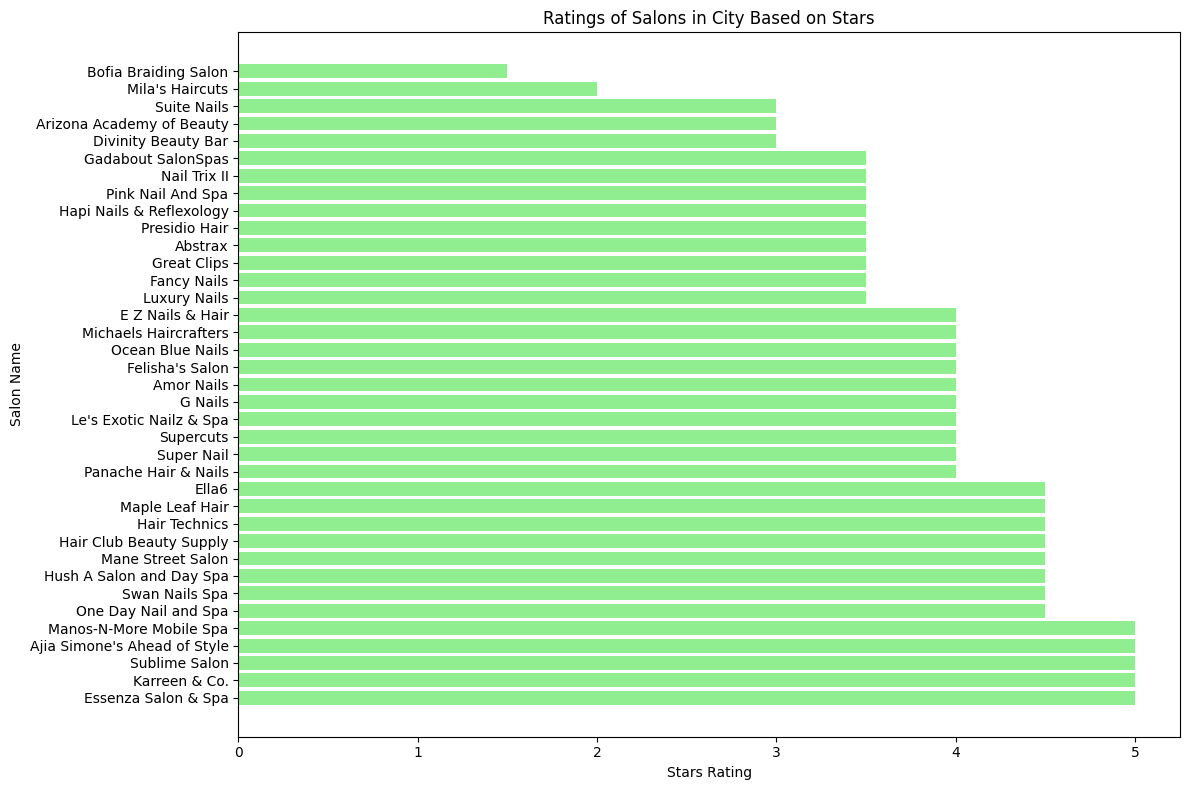

In [145]:
import matplotlib.pyplot as plt
salon_ratings_df = spark.sql("""
select business_id, name as busi_name, stars, postal_code 
from salons
where is_open = 1
and postal_code = '85712'  -- Replace with the desired postal code
order by stars desc
""").toPandas()  

plt.figure(figsize=(12, 8))
plt.barh(salon_ratings_df['busi_name'], salon_ratings_df['stars'], color='lightgreen')
plt.xlabel('Stars Rating')
plt.ylabel('Salon Name')
plt.title('Ratings of Salons in City Based on Stars')
plt.tight_layout()
plt.show()


In [146]:
query_result = spark.sql("""
select s.business_id, s.city, r.text, r.stars 
from salons s 
join review r on s.business_id = r.business_id
""")
df = query_result.toPandas()
df.head()

city_star_counts = df.groupby(['city', 'stars']).size().reset_index(name='count')
city_star_pivot = city_star_counts.pivot_table(index='city', columns='stars', values='count', aggfunc='sum', fill_value=0)
city_star_percent = city_star_pivot.div(city_star_pivot.sum(axis=1), axis=0) * 100


**PIE CHART FOR RATINGS ACROSS THE CITIES IN AZ**

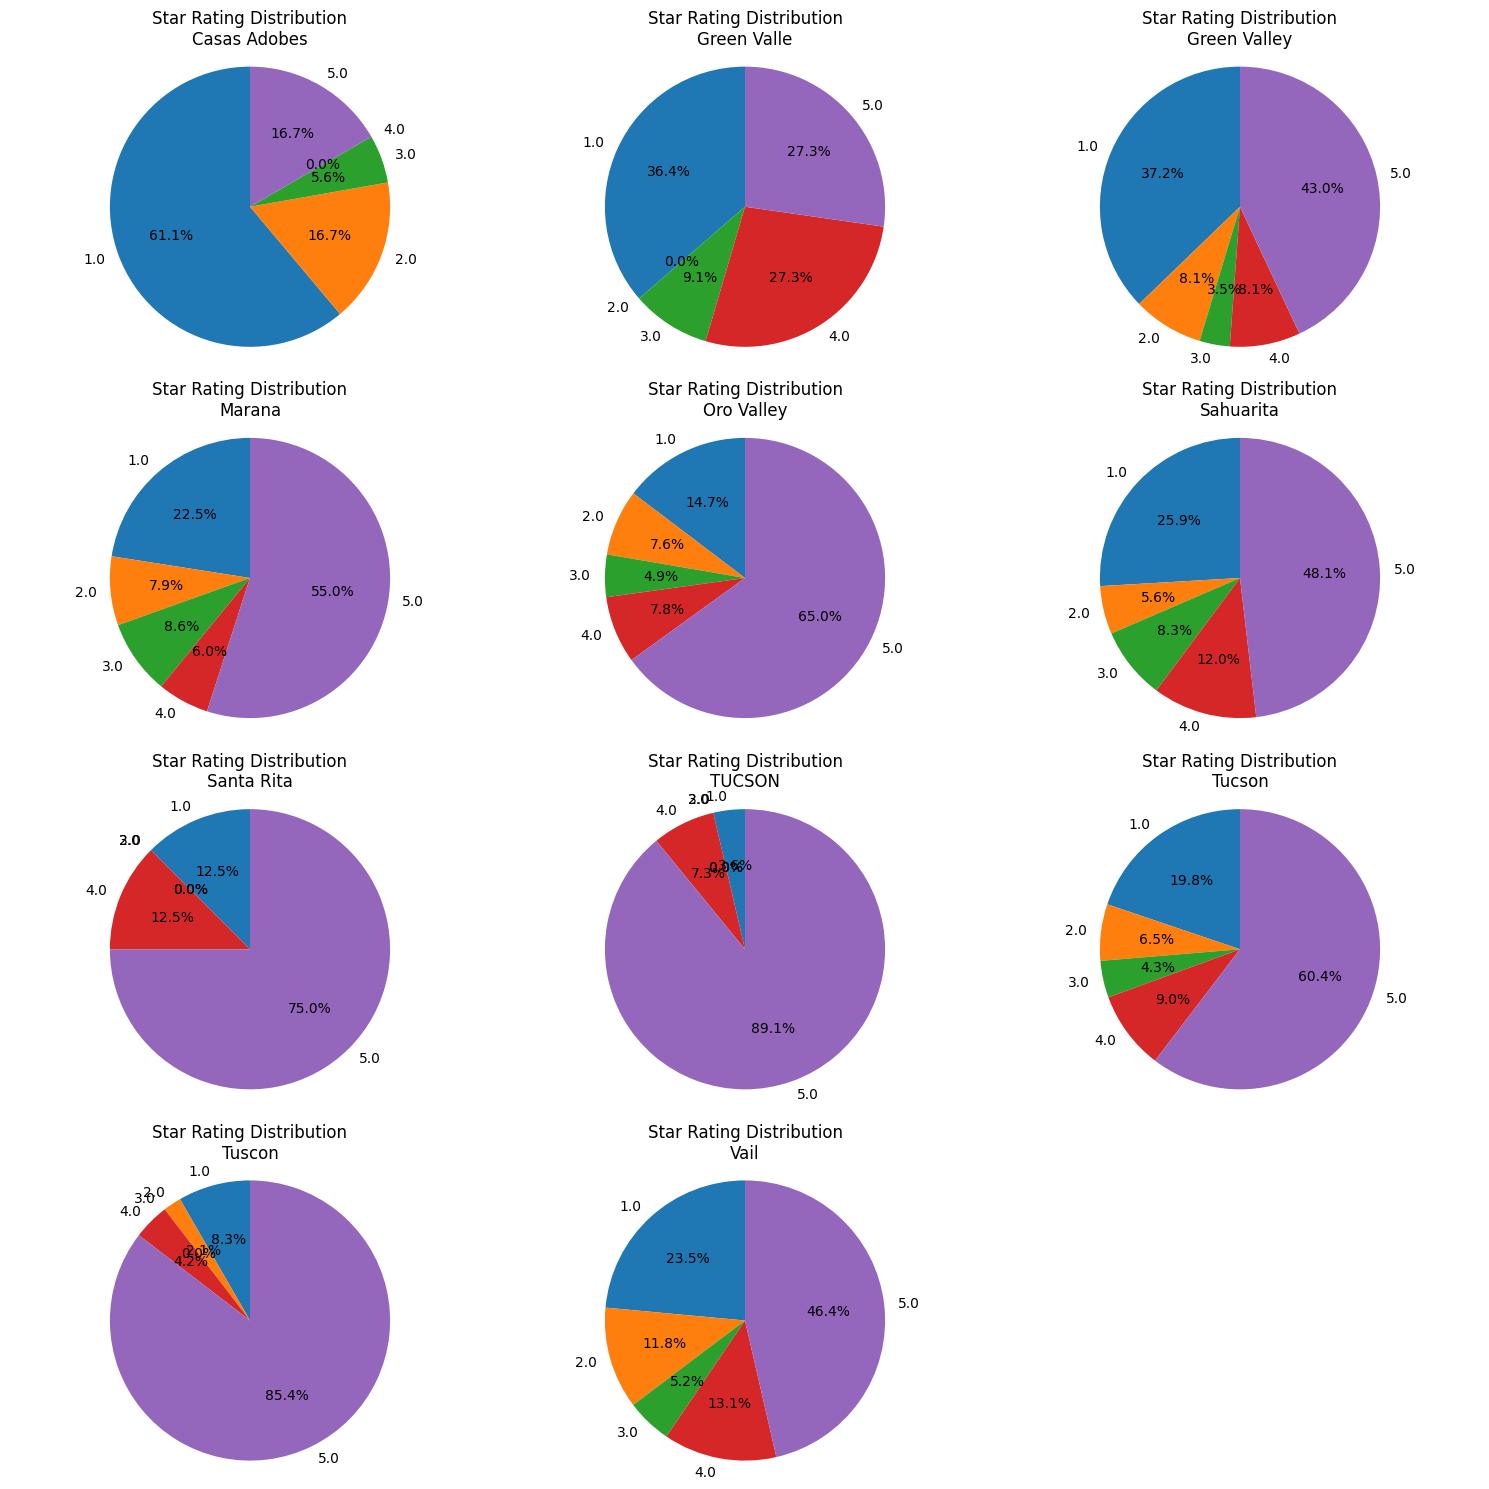

In [147]:
import matplotlib.pyplot as plt
import numpy as np

cities = city_star_percent.index
n_cities = len(cities)
n_cols = 3  
n_rows = np.ceil(n_cities / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

for i, city in enumerate(cities):
    city_data = city_star_percent.loc[city]
    axes[i].pie(city_data, labels=city_data.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"Star Rating Distribution\n{city}")
    axes[i].axis('equal')  

for i in range(n_cities, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()



**RATING DISTRIBUTION ACROSS CITIES**

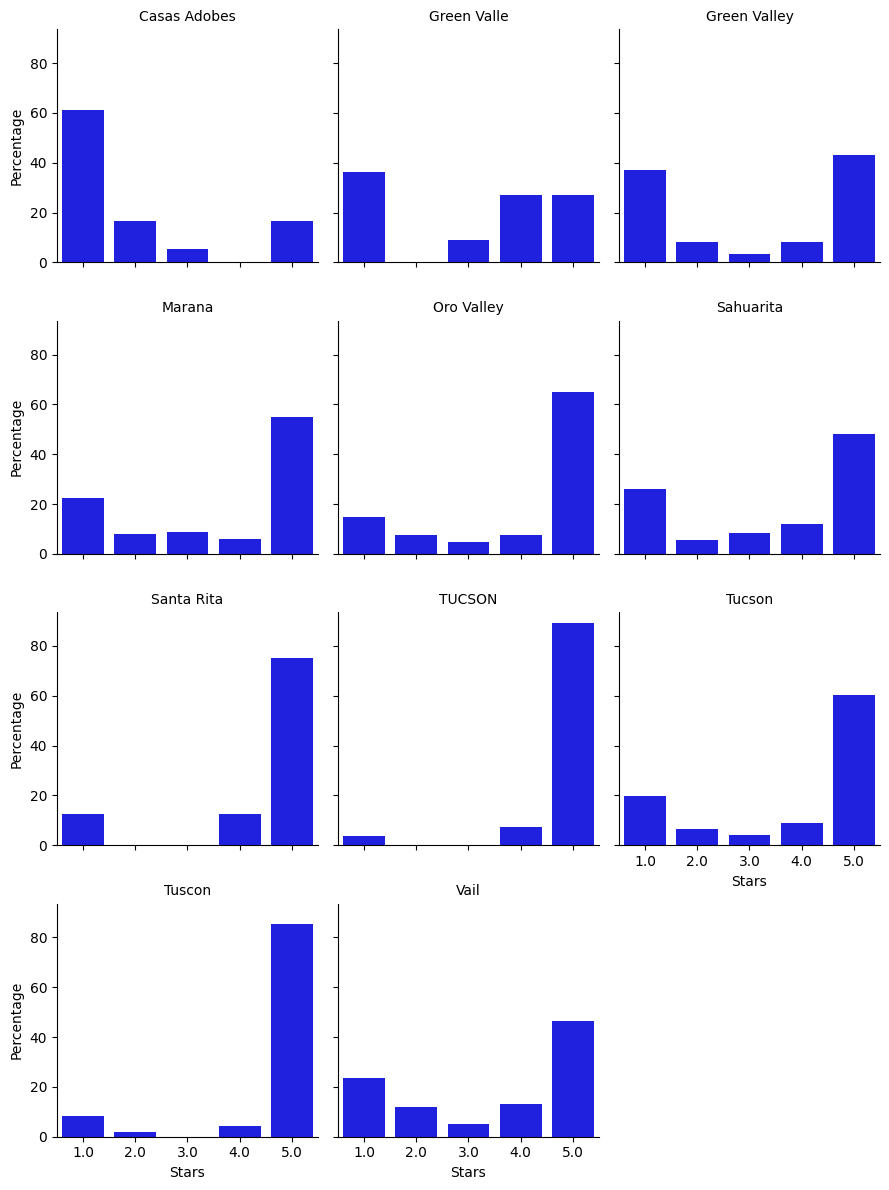

In [148]:
import seaborn as sns

city_star_melted = city_star_percent.reset_index().melt(id_vars='city', value_vars=city_star_percent.columns, var_name='Stars', value_name='Percentage')

g = sns.FacetGrid(city_star_melted, col="city", col_wrap=3, height=3)
g.map(sns.barplot, "Stars", "Percentage", order=city_star_percent.columns, color="blue")

g.set_axis_labels("Stars", "Percentage")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()
